##Importing necessary libraries

In [1]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import cv2
import keras
import matplotlib.pyplot as plt
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##Downloading the data 

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "keshavmalanib21cs038"
os.environ['KAGGLE_KEY']= "5288201eb4ec1af8506e61aee9641f85"


In [ ]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

100% 776M/778M [00:20<00:00, 39.4MB/s]
100% 778M/778M [00:20<00:00, 39.0MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

##Reading the data

In [ ]:
l=['COVID','Lung_Opacity','Normal','Viral Pneumonia']

In [ ]:
img_path=[]
label=[]

In [ ]:
for i in l:
  k=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/images")
  m=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/masks")
  for j in range(len(k)):
    # print(j)
    img_path.append("COVID-19_Radiography_Dataset/"+ i + "/images/"+k[j])
    # mask_path.append("COVID-19_Radiography_Dataset/"+ i + "/masks/"+m[j])
    label.append(i)

In [ ]:
df=pd.DataFrame(img_path,columns = ['image_file'])
# df['mask_file']=mask_path
df['label']=label
df

,image_file,label
0,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
1,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
...,...,...
21160,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21161,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21162,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia


#Preprocessing the data

In [ ]:
x=[]
y=[]
# y2=[]
for i in range(len(df)):
    image = cv2.imread(df['image_file'][i])
    image = cv2.resize(image, (80, 80))/255.0
   
    label = 0
    # label2= 0
    if df['label'][i] == "Normal":
        label = 0
        # label2=0
    elif df['label'][i] == "COVID":
        label = 1
        # label2= 1
    elif df['label'][i] == "Lung_Opacity":
        label = 2
        # label2=0
    else:
        label = 3
        # labwl2= 0
    x.append(image)
    y.append(label)
    # y2.append(label2)

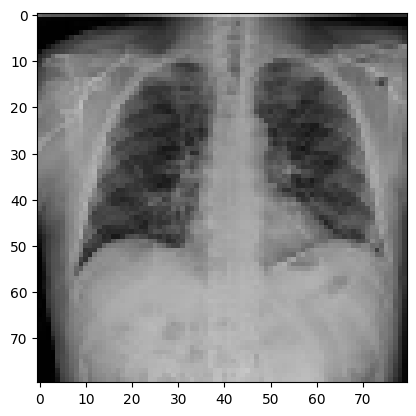

In [ ]:
plt.imshow(x[0])


In [ ]:
x = np.array(x)
y = np.array(y)
# y2 = np.array(y2)
 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(15238, 80, 80, 3) (4233, 80, 80, 3) (1694, 80, 80, 3) (15238,) (4233,) (1694,)


In [ ]:
del x
del y

#Creating the model

In [ ]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 256, activation = 'relu'))
    
    cnn_model.add(layers.Dropout(0.2))
    cnn_model.add(layers.Dense(units = 64, activation = 'relu'))

    cnn_model.add(layers.Dense(units = 32,activation='relu'))
    cnn_model.add(layers.Dense(units = 4))
    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [ ]:
input_shape = (80, 80,3)
n_classes= 4
conv_model2 = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 32)        0

In [ ]:
plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

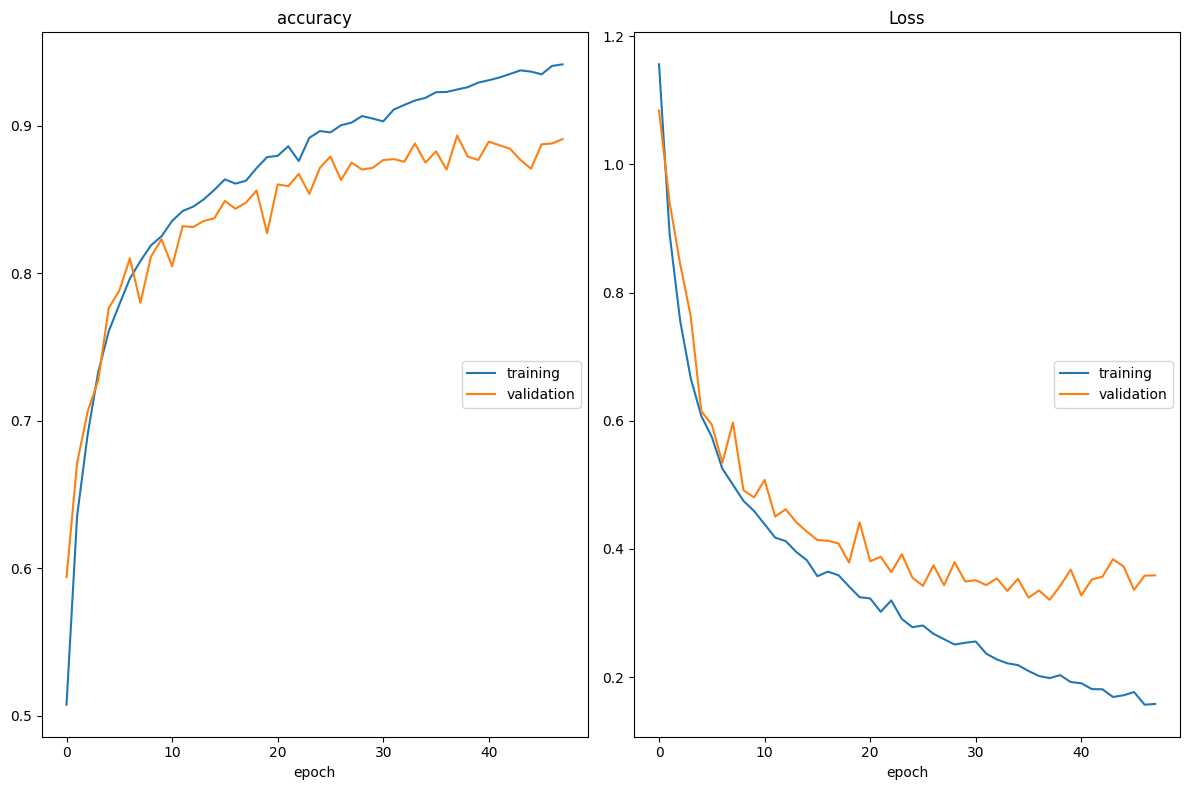

accuracy
	training         	 (min:    0.507, max:    0.941, cur:    0.941)
	validation       	 (min:    0.594, max:    0.893, cur:    0.891)
Loss
	training         	 (min:    0.157, max:    1.156, cur:    0.158)
	validation       	 (min:    0.320, max:    1.084, cur:    0.359)
60/60 [==============================] - 3s 47ms/step - loss: 0.1580 - accuracy: 0.9415 - val_loss: 0.3586 - val_accuracy: 0.8908
CPU times: user 2min 21s, sys: 16.8 s, total: 2min 37s
Wall time: 2min 39s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model2.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)

#Evaluating the model

In [ ]:
yp_train = conv_model2.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model2.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model2.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 0s 3ms/step


In [ ]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")


In [ ]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7334
           1       0.91      0.97      0.94      2639
           2       0.96      0.85      0.90      4290
           3       0.97      0.99      0.98       975

    accuracy                           0.93     15238
   macro avg       0.94      0.94      0.94     15238
weighted avg       0.93      0.93      0.93     15238

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       834
           1       0.83      0.89      0.86       276
           2       0.89      0.78      0.83       476
           3       0.92      0.91      0.92       108

    accuracy                           0.88      1694
   macro avg      

#Applying LDA on flatten layer output of CNN

In [ ]:
flatten_layer = conv_model2.layers[8]
flatten_layer


In [ ]:
flatten_model = tf.keras.Model(inputs=conv_model2.inputs, outputs=flatten_layer.output)
flatten_output = flatten_model.predict(x)

662/662 [==============================] - 10s 3ms/step


In [ ]:
flatten_output.shape

(21165, 4096)

In [ ]:
my_dataframe = pd.DataFrame(flatten_output)

In [ ]:
my_dataframe

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.000000,0.177918,0.000000,0.000000,0.0000,0.000000,0.069278,0.0,0.004374,0.045136,...,0.265857,0.0,0.044456,0.061126,0.138720,0.0,0.302218,0.0,0.000000,0.085974
1,0.000000,0.098800,0.000000,0.026374,0.0000,0.000000,0.056029,0.0,0.006626,0.012166,...,0.249892,0.0,0.120142,0.043198,0.244101,0.0,0.330054,0.0,0.000000,0.096211
2,0.000000,0.217416,0.000000,0.000000,0.0000,0.000000,0.100713,0.0,0.038931,0.021537,...,0.320286,0.0,0.048778,0.046925,0.159187,0.0,0.359158,0.0,0.000000,0.106546
3,0.000000,0.181422,0.000000,0.000000,0.0000,0.000000,0.074840,0.0,0.034897,0.015427,...,0.337210,0.0,0.055435,0.068877,0.200157,0.0,0.372834,0.0,0.000000,0.107944
4,0.015069,0.146061,0.000000,0.044268,0.0000,0.000000,0.056678,0.0,0.030043,0.007353,...,0.323740,0.0,0.077060,0.055525,0.169230,0.0,0.331230,0.0,0.002809,0.092686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21160,0.000000,0.094157,0.000000,0.019625,0.0199,0.010833,0.018398,0.0,0.136412,0.021863,...,0.246286,0.0,0.078253,0.028202,0.231540,0.0,0.305811,0.0,0.000000,0.084138
21161,0.000000,0.139799,0.014198,0.000000,0.0000,0.008896,0.052228,0.0,0.081704,0.010008,...,0.223741,0.0,0.040517,0.032140,0.123706,0.0,0.247190,0.0,0.000000,0.072334
21162,0.000000,0.081456,0.000000,0.037334,0.0000,0.051872,0.005557,0.0,0.143240,0.101326,...,0.290123,0.0,0.084221,0.020303,0.236594,0.0,0.342724,0.0,0.000000,0.107631
21163,0.000000,0.119420,0.000000,0.000000,0.0000,0.013362,0.042064,0.0,0.082605,0.005190,...,0.266699,0.0,0.062685,0.024886,0.170792,0.0,0.330504,0.0,0.000000,0.088488


In [ ]:
y=[]
for i in range(21165):
  if(i<3616) : y.append(0)
  elif(i>=3616 and i<9628) : y.append(1)
  elif(i>=9628 and i<19820) : y.append(2)
  else: y.append(3)
 
Y = np.asarray(y)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit_transform(my_dataframe, Y)

# Transform the training and testing data to 3 dimensions

array([[ 0.22730016,  0.55967672, -3.67909288],
       [-0.02034933,  3.23933132, -1.6864661 ],
       [ 1.37909815,  1.7892802 , -1.83543225],
       ...,
       [ 8.41493262, -0.87856422,  0.31326646],
       [ 5.20108792, -0.85270283,  0.94143856],
       [ 8.50100851, -0.35442046,  0.56982924]])

In [ ]:
my_dataframe = lda.fit_transform(my_dataframe, Y)


In [ ]:
my_dataframe.shape
my_dataframe = pd.DataFrame(my_dataframe, columns=['Column 1', 'Column 2', 'Column 2'])

In [ ]:
my_dataframe.shape

(21165, 3)

In [ ]:
my_dataframe.to_csv('lda_data.csv')#downloading the data to be used for other models